In [24]:
import sys
sys.path.append('C:/Users/Billy/Documents/PRISMO/Backtester')
from multiprocessing import Process
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import time
import random
from mathCode.johansenMain import coint_johansen
from tqdm import tqdm_notebook
from IPython.display import clear_output
import itertools
import datetime
import os
from base_model_backtest import backtest
import random
from pandas_datareader import data as pdr
import logging
from pandas.plotting import register_matplotlib_converters
from functionSource import *

register_matplotlib_converters()
formatter = logging.Formatter('%(asctime)s %(levelname)s %(message)s')
plt.style.use(['ggplot'])

from operator import itemgetter

from models.Cointegrated_Pairs_1 import cointegrated_pairs_1


        
global toTrade
global price
global df
global results
global runDate


In [4]:
df = pd.read_csv('D:/Machine_learning_finance/raw_data/ewaewcige.csv')
base = datetime.datetime.today()
date_list = [base + datetime.timedelta(days=x) for x in range(len(df))]
df.index = date_list
prices = np.array([df.ewc,df.ewa]).T

features = df.columns
features = [ 'ewc', 'ewa', 'ige']
toTrade = features

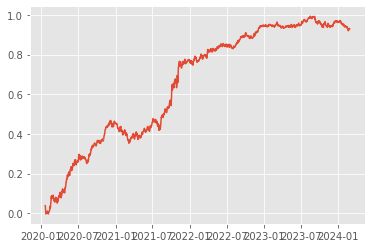

In [28]:
ve_values = []
delta_values = []
for ve_ in range(1,10):
    order = round(0.1**(ve_+1), 12)
    for i in range(1,10):
        ve_values.append(round(i*order*100,12))
        delta_values.append(round(i*order,12))

ve_values = [1e-06]
delta_values = [4e-10]

results = []
for delta in delta_values:
    for ve in ve_values:
        close = df
        
        features = [ 'ewc', 'ewa', 'ige']
        toTrade = features
        yhat = [np.matrix(0)]           #stores the measurement prediction of the linear model y (t) = x(t)*β(t) + e(t). Store for each time step.

        #The variance in the measurement prediction. Store for each time step.
        Q = []

        #The prediction error at each time step.
        e = []

        #Store the beta values
        beta_list = [np.matrix([[0],[0],[0]])]

        #Covariance Arrays,  measuring the covariance of the error of the hidden variable, β,  estimates
        #For clarity, we denote R(t|t) by P, and R(t|t-1) as R. R(t | t − 1) is cov(β(t) − βhat(t|t-1))
        R = np.zeros([len(features),len(features)])
        P = np.zeros([len(features),len(features)])

        #delta is a pre-defined value, but can be trained from the dataset, delta of 0 means we're just doing linear regression
        Vw = delta/(1-delta)*np.diag(np.ones(len(features)))


        #Decimal Places should be assigned globally for transparency

        #Store the hedge ratios
        hedges = []

        # # For validation
        # # DELETE FOR SPEED
        # self.yhat_val = []
        y = []
        yhatPlusQ = []
        yhatMinusQ = []
        # self.Q = []

        hedges = []

        #The underlying time series, e.g. we use the snp500 for the ASX if we're testing aussie assets.


        for row in df.iterrows():
            row = list(list(row)[1])
            y = np.matrix(row[3])
            x = np.matrix([[row[1]],[row[2]],[1]])


            beta = beta_list[-1]
            R = P + Vw

            yhat = np.dot(x.T, beta)
            e_t = y - yhat 
            Q_t = np.dot( np.dot(x.T, R) , x ) + ve

            K = np.matrix(np.dot(R, x)/Q_t)
            beta = beta + K*e_t
            P = R - np.dot(np.dot(K, x.T), R)
            e.append(e_t.tolist()[0][0])
            Q.append(Q_t.tolist()[0][0])
            beta_list.append(beta)

            hedges.append([beta.tolist()[0][0],beta.tolist()[1][0]])
        #     beta = beta[-1]

        close.loc[slice(None),'e'] = e
        close.loc[slice(None),'Q'] = Q

        # if np.mean(close['e'])>np.sqrt(np.mean(close['Q'])):
        # #                 print('means',np.mean(close['e']), np.sqrt(np.mean(close['Q'])))
        # #             if the average error is greater than the average deviation the parameters are fucked. No point going further
        #     break


        close.loc[slice(None),'LongEntry'] = close['e']<-np.sqrt(close['Q'])
        close.loc[slice(None),'LongExit'] = close['e']>-np.sqrt(close['Q'])
        close.loc[slice(None),'ShortEntry'] = close['e']>np.sqrt(close['Q'])
        close.loc[slice(None),'ShortExit'] = close['e']<np.sqrt(close['Q'])

        numUnitsLong = np.array([[np.nan]]*len(close))
        numUnitsShort = np.array([[np.nan]]*len(close))

        numUnitsLong[0] = 1
        numUnitsLong[np.array(close['LongEntry'])] = 1
        numUnitsLong[np.array(close['LongExit'])] = 0

        numUnitsShort[0] = 1
        numUnitsShort[np.array(close['ShortEntry'])] = -1
        numUnitsShort[np.array(close['ShortExit'])] = 0

        close.loc[slice(None),'short'] = numUnitsShort
        close.loc[slice(None),'short'].fillna('ffill')
        close.loc[slice(None),'long'] =  numUnitsLong
        close.loc[slice(None),'long'].fillna('ffill')

        close.loc[slice(None),'numUnits'] = close['long'] + close['short']

        close.loc[slice(None),'numUnits'+toTrade[0]] = -close['numUnits']*[x[0] for x in hedges]
        close.loc[slice(None),'numUnits'+toTrade[1]] = -close['numUnits']*[x[1] for x in hedges]

        close.loc[slice(None),'numUnits'+toTrade[2]] = close['numUnits']

        close.loc[slice(None),'positions'+toTrade[0]] = close['numUnits'+toTrade[0]]*close[toTrade[0]]
        close.loc[slice(None),'positions'+toTrade[1]] = close['numUnits'+toTrade[1]]*close[toTrade[1]]
        close.loc[slice(None),'positions'+toTrade[2]] = close['numUnits'+toTrade[2]]*close[toTrade[2]]

        close.loc[slice(None),'pnl'] =sum([ close[asset].pct_change()*close['positions'+asset].shift(1) for asset in toTrade])


        close.loc[slice(None),'returns'] = (close['pnl'])/(np.abs(close['positions'+toTrade[0]]) +np.abs(close['positions'+toTrade[0]])).shift(1)
        close.loc[slice(None),'returns']= close['returns'][abs(close['returns'])<0.1]
        plt.plot(np.cumsum(close['returns']))
        results.append([delta, ve, np.cumsum(close['returns']).dropna()[-1]])

In [25]:
sorted(results,key=itemgetter(2),reverse=True)

[[4e-10, 1e-06, 0.929923956796219],
 [2e-10, 5e-07, 0.9259883553354306],
 [8e-10, 2e-06, 0.9249769569350754],
 [7e-10, 2e-06, 0.9232329173691451],
 [2e-09, 5e-06, 0.9173925245646326],
 [3e-10, 9e-07, 0.9152993737127252],
 [1e-08, 3e-05, 0.9149233148707753],
 [2e-10, 6e-07, 0.9140211468394405],
 [1e-09, 3e-06, 0.9111519354393454],
 [2e-09, 6e-06, 0.9090370991484907],
 [1e-10, 3e-07, 0.9051152203995505],
 [3e-08, 8e-05, 0.8994013067510572],
 [8e-09, 2e-05, 0.8993241933352473],
 [3e-09, 8e-06, 0.8992802645504483],
 [3e-09, 9e-06, 0.8953390969534656],
 [2e-08, 6e-05, 0.8934905534441323],
 [7e-09, 2e-05, 0.89159139863705],
 [3e-10, 8e-07, 0.8912501185753151],
 [4e-09, 1e-05, 0.8895669762945595],
 [8e-08, 0.0001, 0.8886000471493755],
 [3e-09, 7e-06, 0.886444681092423],
 [7e-08, 9e-05, 0.8862870168412391],
 [3e-10, 7e-07, 0.8839258360625116],
 [6e-08, 8e-05, 0.8797226742051572],
 [4e-10, 9e-07, 0.8791725694479137],
 [6e-09, 2e-05, 0.87599318882239],
 [8e-08, 9e-05, 0.8757040595264455],
 [9e-0

In [27]:
x = [[4e-10, 1e-06, 0.929923956796219],
 [2e-10, 5e-07, 0.9259883553354306],
 [8e-10, 2e-06, 0.9249769569350754],
 [7e-10, 2e-06, 0.9232329173691451],
 [2e-09, 5e-06, 0.9173925245646326],
 [3e-10, 9e-07, 0.9152993737127252],
 [1e-08, 3e-05, 0.9149233148707753],
 [2e-10, 6e-07, 0.9140211468394405],
 [1e-09, 3e-06, 0.9111519354393454],
 [2e-09, 6e-06, 0.9090370991484907],
 [1e-10, 3e-07, 0.9051152203995505],
 [3e-08, 8e-05, 0.8994013067510572],
 [8e-09, 2e-05, 0.8993241933352473],
 [3e-09, 8e-06, 0.8992802645504483],
 [3e-09, 9e-06, 0.8953390969534656],
 [2e-08, 6e-05, 0.8934905534441323],
 [7e-09, 2e-05, 0.89159139863705]]